In [2]:
import pandas as pd
import numpy as np

In [3]:
from style import plotly_apply
plotly_apply()

In [4]:
def construccion_de_A(T: int) -> np.ndarray:
    """Construye la matriz A, que es una matriz de diferencias finitas de segundo orden."""
    A = np.zeros((T-2, T))      # Crea una matriz de ceros de tamaño (T-2) x T
    for i in range(T-2):        # Llena la matriz A con los coeficientes de diferencias finitas
        A[i, i:i+3] = 1, -2, 1
    return A    

# Hacerlo una funcion
def hodrick_prescott_filter(series: pd.Series, lamb: float) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """Aplica el filtro de Hodrick-Prescott a una serie temporal.
    
    Args:
        series (pd.Series): Serie temporal a la que se le aplicará el filtro.
        lamb (float): Parámetro de suavizamiento del filtro.
        
    Returns:
        tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]: Una tupla que contiene la tendencia, el ciclo y la desviación porcentual.
    """
    index = series.index
    name = series.name
    series = np.asarray(series).flatten()

    N = len(series)
    A = construccion_de_A(N)

    tendencia = np.linalg.inv(np.identity(N) + lamb * (A.T @ A)) @ series
    ciclo = series - tendencia
    desviacion = 100 * (series / tendencia - 1)

    tendencia = pd.DataFrame(tendencia, index=index, columns=[name])
    ciclo = pd.DataFrame(ciclo, index=index, columns=[name])
    desviacion = pd.DataFrame(desviacion, index=index, columns=[name])

    return tendencia, ciclo, desviacion

In [5]:
gpd = pd.read_csv('GDP EEUU', index_col=0, parse_dates=True, names=['Fecha', 'GDP'], header=0)
tendencia, ciclo, desviacion = hodrick_prescott_filter(gpd['GDP'], lamb=1600)

In [6]:
gpd['GDP'].plot(title='Producto Interno Bruto Real de Estados Unidos (Billones de Dólares)')
tendencia.plot(title='Tendencia del Producto Interno Bruto Real de Estados Unidos (Billones de Dólares)')
ciclo.plot(title='Ciclo del Producto Interno Bruto Real de Estados Unidos (Billones de Dólares)')
#desviacion.plot(title='Desviación Porcentual del Producto Interno Bruto Real de Estados Unidos (%)')

**Poner la serie en escala logaritmica sirve de tres cosas clave:**

1. Modelo multiplicativo → aditivo.
   Si $Y_t=T_t\cdot C_t$ con ciclo proporcional al nivel, entonces
   $\log Y_t=\tau_t+c_t$. El HP trabaja mejor con $c_t$ de amplitud aproximadamente constante. Sin log, $Y_t=\tau_t+c_t$ impone ciclos de tamaño absoluto fijo, lo que suele ser falso en macro.

2. Estabilizar varianza y hacer ARMA plausible.
   $\operatorname{Var}(Y_t)$ suele crecer con el nivel. En log, $\operatorname{Var}(\log Y_t)$ es más estable. Los residuos del ciclo se acercan a homocedasticidad y a gaussianidad, lo que mejora ajuste y pronóstico ARMA del ciclo.

3. Interpretación económica directa.
   $\Delta \log Y_t \approx g_t$ es tasa de crecimiento. Pronosticar en log produce bandas y errores en porcentajes, que es lo que importa en práctica.

Detalles útiles:

* Requiere $Y_t>0$. Si hay ceros, use $\log(1+Y_t)$ o un shift positivo y documente la interpretación.
* Al volver a niveles, corrija el sesgo por Jensen si asume normalidad: si $\hat y\sim \mathcal N(\mu,\sigma^2)$, entonces $E[Y]\approx \exp(\mu+\tfrac12\sigma^2)$.
* El $\lambda$ del HP no cambia por escalar la serie, pero el log no es un simple reescalado: cambia la relación nivel–volatilidad y hace más lineal la tendencia.


In [7]:
y = np.log(gpd['GDP'])
tendencia, ciclo, desviacion = hodrick_prescott_filter(y, lamb=1600)

**Se hace ARMA en el ciclo porque ARMA exige estacionariedad y el ciclo sí la cumple; la tendencia HP no.**

* Descomposición: $y_t=\tau_t+c_t$, con $E[c_t]=0$, $c_t$ ≈ estacionario; $\tau_t$ es no estacionaria de baja frecuencia.
* Supuesto ARMA: procesos covarianza-estacionarios alrededor de media constante. Eso describe $c_t$, no $\tau_t$.
* El HP impone suavidad vía $\min_{\tau}\sum(y_t-\tau_t)^2+\lambda\sum(\Delta^2\tau_t)^2$. Esa dinámica equivale a un “trend” tipo I(2) local, no a ARMA.
* Poner ARMA sobre $\tau_t$ fuerza a diferenciarla. Modelar $\Delta\tau_t$ o $\Delta^2\tau_t$ destruye la separación tendencia–ciclo y te devuelve a un ARIMA sobre $y_t$.
* Identificación de frecuencias: ARMA sobre $\tau_t$ reintroduce componentes de media cero y “contamina” el ciclo.
* Borde temporal: la $\tau_t$ de HP es inestable en los extremos; ARMA no corrige eso. Un modelo estructural sí.
* Práctica estándar:

  * Ciclo: $c_t=\Phi(B)^{-1}\Theta(B)\varepsilon_t$ (ARMA).
  * Tendencia: local linear trend en espacio de estados
    $\tau_t=\tau_{t-1}+\beta_{t-1}+\eta_t,\quad \beta_t=\beta_{t-1}+\zeta_t$
    o RW con deriva.
* Pronóstico coherente: $\hat y_{T+h}=\hat\tau_{T+h|T}+\hat c_{T+h|T}$.
* Si insistes en “ARMA de tendencia”: ajusta ARMA a $\Delta^2\tau_t$ y luego integra dos veces. Es redundante frente a ARIMA/estructurales y pierde claridad.


In [8]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from scipy.stats import jarque_bera

In [10]:
ciclo = ciclo.asfreq('QS-JAN')  # evita warning

In [11]:
def get_all_combinations(p: int) -> list[tuple[int, ...]]:
    """Genera todas las combinaciones posibles de ceros y unos de longitud hasta p, 
    asegurando que cada combinación termine en 1, y que la combinación (0,) esté incluida.
    
    Args:
        p (int): La longitud máxima de las combinaciones.
        
    Returns:
        list[tuple[int, ...]]: Una lista de tuplas que representan las combinaciones.
    """
    all_combinations = []
    all_combinations.append((0,))  # Include the (0,) combination
    for i in range(1, p+1):
        for comb in product([0, 1], repeat=i):
            if comb[-1] == 1:  # Only include combinations ending with 1
                all_combinations.append(comb)
    return all_combinations

In [12]:
p_combs = get_all_combinations(3)
p_combs

[(0,), (1,), (0, 1), (1, 1), (0, 0, 1), (0, 1, 1), (1, 0, 1), (1, 1, 1)]

In [39]:
idx = ciclo.index

Pulse/dummy: una columna adicional que vale 1 solo en 2020‑04 y 0 en el resto. Su coeficiente captura el efecto puntual (Additive Outlier, AO).

In [38]:
ao_2020_04 = (idx == pd.Timestamp('2020-04-01')).astype(int)
ao_2020_04

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,

In [40]:
# Opcionales: otras intervenciones
ls_from_2020_04 = (idx >= pd.Timestamp('2020-04-01')).astype(int)   # level shift
delta = 0.7  # tasa de decaimiento (0<delta<1) para TC
tc = np.zeros(len(y))
start = np.where(idx == pd.Timestamp('2020-04-01'))[0]
if len(start):
    s = start[0]
    tc[s:] = delta ** np.arange(0, len(y) - s)

exog = pd.DataFrame({
    'ao_2020_04': ao_2020_04,
    # 'ls_from_2020_04': ls_from_2020_04,  # si aplica
    # 'tc_2020_04': tc,                     # si aplica
}, index=idx)


In [42]:
ARIMA(ciclo, order=(1, 0, 1), trend='n',
                        enforce_stationarity=True, enforce_invertibility=True, 
                        exog=exog).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    GDP   No. Observations:                  314
Model:                 ARIMA(1, 0, 1)   Log Likelihood                1075.091
Date:                Mon, 08 Sep 2025   AIC                          -2142.182
Time:                        20:17:46   BIC                          -2127.184
Sample:                    01-01-1947   HQIC                         -2136.189
                         - 04-01-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ao_2020_04    -0.0757      0.006    -13.169      0.000      -0.087      -0.064
ar.L1          0.7800      0.035     22.080      0.000       0.711       0.849
ma.L1          0.2852      0.056      5.107      0.000       0.176       0.395
sigma2      6.181e-05   3.55e-06     17.404      0.000    5.49e-05    6.88e-05
===================================================================================
Ljung-Box (L1) (Q):                   1.02   Jarque-Bera (JB):                55.70
Prob(Q):                              0.31   Prob(JB):                         0.00
Heteroskedasticity (H):               0.28   Skew:                            -0.40
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:


def _roots_ok(m, margin=1.02):
    """Verifica que las raíces del modelo ARMA estén fuera del círculo unitario con un margen dado, el margen por defecto es 1.02, significa que las raíces deben estar al menos al 102% de la distancia del círculo unitario, una raíz en el círculo unitario tiene valor absoluto 1."""
    # raíces fuera del círculo unitario con margen
    ok_ar = (len(m.arroots)==0) or (np.min(np.abs(m.arroots)) > margin)
    ok_ma = (len(m.maroots)==0) or (np.min(np.abs(m.maroots)) > margin)
    return ok_ar and ok_ma

def _resid_tests(resid, lags=(12, 24), alpha=0.05):
    resid = pd.Series(resid).dropna()
    # Blanco: Ljung–Box en varios lags
    lb = acorr_ljungbox(resid, lags=max(lags), return_df=True)
    ok_lb = all(lb.loc[lag, 'lb_pvalue'] > alpha for lag in lags if lag <= len(lb))
    # ARCH: no heterocedasticidad condicional
    arch_stat, arch_p, _, _ = het_arch(resid, nlags=min(12, max(5, len(resid)//20)))
    ok_arch = arch_p > alpha
    # Normalidad: Jarque–Bera (criterio suave)
    jb_stat, jb_p, skew, kurt = jarque_bera(resid)
    return {
        'ok_lb': ok_lb, 'ok_arch': ok_arch, 'ok_jb': jb_p > alpha,
        'jb_p': jb_p, 'arch_p': arch_p,
        'lb_p@{}': float(lb.iloc[min(max(lags), len(lb))-1]['lb_pvalue'])
    }

def seleccionar_arma_ciclo(serie, max_p=3, max_q=3, alpha=0.05):
    """
    serie: ciclo HP (media ~0), Index temporal regular.
    Devuelve el mejor modelo que CUMPLE supuestos. Fallback: mejor AIC con motivos.
    """
    y = pd.Series(serie).dropna()
    if y.index.freq is None:
        y = y.asfreq(pd.infer_freq(y.index))

    candidatos = []
    fallback = None
    p_combs = get_all_combinations(max_p)
    q_combs = get_all_combinations(max_q)

    for p, q in product(p_combs, q_combs):        # se usa product para generar pares (p,q)
        try:
            # Tendencia nula en ciclo; forzar restricciones
            mod = ARIMA(y, order=(p, 0, q), trend='n',
                        enforce_stationarity=True, enforce_invertibility=True, 
                        exog=exog)
            res = mod.fit()
            # guardar fallback por AIC
            if fallback is None or res.aic < fallback[0]:
                fallback = (res.aic, (p, q), res, None)

            # raíces con margen
            if not _roots_ok(res):
                continue

            # diagnósticos de residuos
            tests = _resid_tests(res.resid, lags=(12, 24), alpha=alpha)
            # criterio: blanco y sin ARCH; normalidad opcional pero preferida
            if tests['ok_lb'] and tests['ok_arch']:
                # penaliza si no normal, pero acepta
                score = res.aic + (0 if tests['ok_jb'] else 2.0)
                candidatos.append((score, (p, q), res, tests))
        except Exception:
            continue

    if candidatos:
        candidatos.sort(key=lambda z: z[0])
        return {'order': candidatos[0][1], 'result': candidatos[0][2], 'tests': candidatos[0][3], 'fallback_used': False}
    else:
        return {'order': fallback[1], 'result': fallback[2], 'tests': fallback[3], 'fallback_used': True}


In [16]:
sel = seleccionar_arma_ciclo(y, max_p=3, max_q=3, alpha=0.1)

c:\Users\herie\miniconda3\envs\u\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\herie\miniconda3\envs\u\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\herie\miniconda3\envs\u\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\herie\miniconda3\envs\u\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\herie\miniconda3\envs\u\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\herie\miniconda3\envs\u\Lib\site-packages

In [17]:
sel

{'order': ((1,), (1, 0, 1)),
 'result': <statsmodels.tsa.arima.model.ARIMAResultsWrapper at 0x202072691d0>,
 'tests': None,
 'fallback_used': True}

In [18]:
best_model = sel['result']
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                
===============================================================================
Dep. Variable:                     GDP   No. Observations:                  314
Model:             ARIMA(1, 0, [1, 3])   Log Likelihood                 933.999
Date:                 Mon, 08 Sep 2025   AIC                          -1859.998
Time:                         20:02:41   BIC                          -1845.000
Sample:                     01-01-1947   HQIC                         -1854.005
                          - 04-01-2025                                         
Covariance Type:                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000   3.45e-05    2.9e+04      0.000       1.000       1.000
ma.L1          1.9204      0.375      5.120      0.000       1.185       2.656
ma.L3          0.9544      0.089     10.680      0.000       0.779       1.129
sigma2      3.222e-05   1.04e-05      3.112      0.002    1.19e-05    5.25e-05
===================================================================================
Ljung-Box (L1) (Q):                   2.91   Jarque-Bera (JB):              8973.39
Prob(Q):                              0.09   Prob(JB):                         0.00
Heteroskedasticity (H):               1.44   Skew:                             0.82
Prob(H) (two-sided):                  0.06   Kurtosis:                        29.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

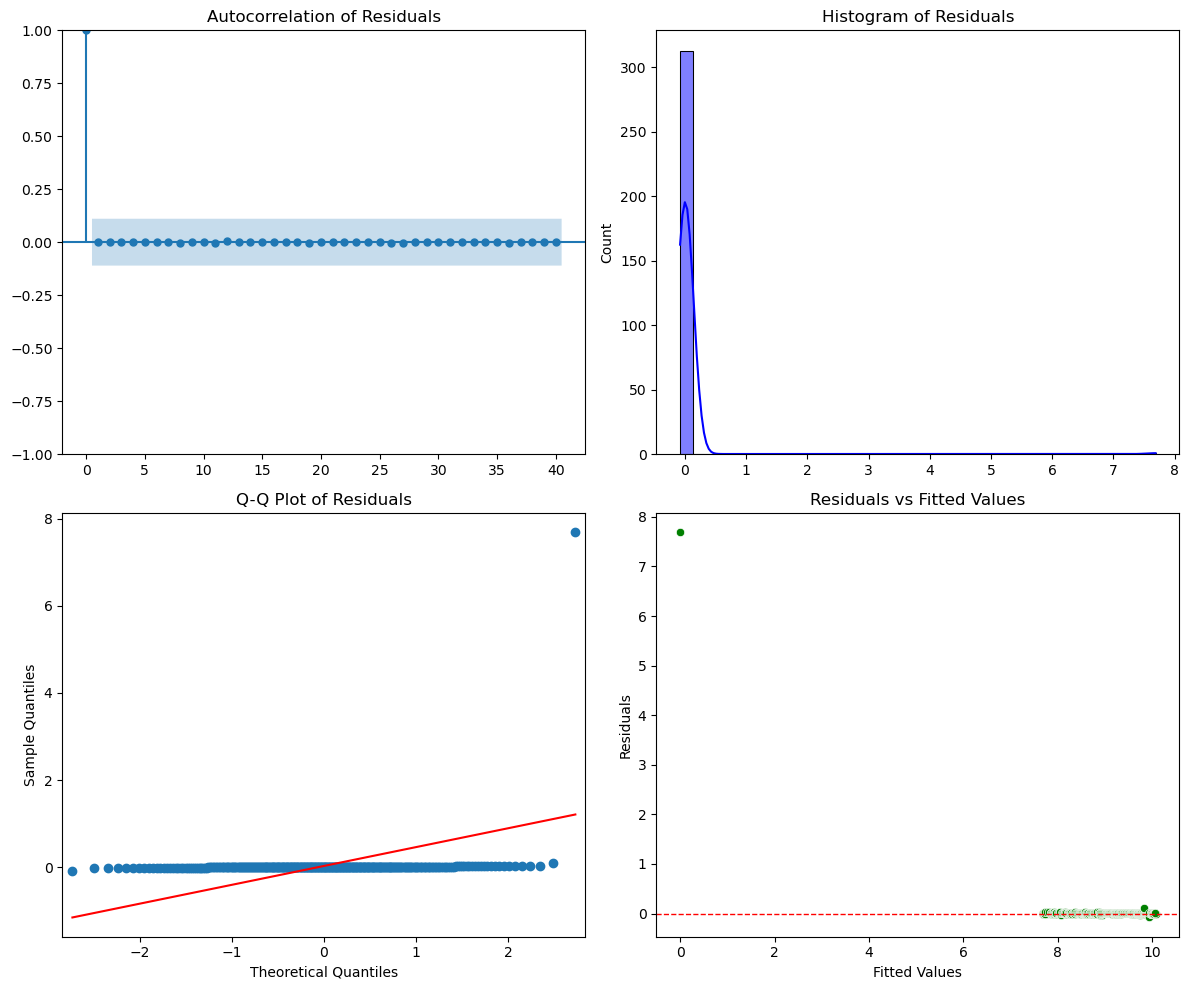

In [ ]:
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Autocorrelation plot
sm.graphics.tsa.plot_acf(best_model.resid.dropna(), lags=40, ax=axes[0, 0])
axes[0, 0].set_title('Autocorrelation of Residuals')

# Histogram with KDE
sns.histplot(best_model.resid.dropna(), kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Histogram of Residuals')

# Q-Q Plot
sm.qqplot(best_model.resid.dropna(), line='s', ax=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot of Residuals')

# Residuals vs Fitted Values
sns.scatterplot(x=best_model.fittedvalues, y=best_model.resid, ax=axes[1, 1])
axes[1, 1].axhline(0, linestyle='--', color='red', linewidth=1)
axes[1, 1].set_title('Residuals vs Fitted Values')
axes[1, 1].set_xlabel('Fitted Values')
axes[1, 1].set_ylabel('Residuals')

plt.tight_layout()
plt.show()

In [ ]:
fc = res.get_forecast(h)
mean = fc.predicted_mean
ci = fc.conf_int(alpha=alpha)
return mean, ci

In [ ]:
def pronosticar_ciclo(res, h=12, alpha=0.2):


def plot_ciclo_con_pronostico(ciclo, res, h=12, alpha=0.2, titulo='Ciclo HP + ARMA'):
    mean, ci = pronosticar_ciclo(res, h=h, alpha=alpha)
    idx_hist = ciclo.index
    idx_fc = mean.index

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.axhline(0.0, linewidth=0.8)
    ax.plot(idx_hist, ciclo, label='Ciclo HP')
    ax.plot(idx_fc, mean, label='Pronóstico ciclo', linewidth=1.8)
    ax.fill_between(idx_fc, ci.iloc[:, 0], ci.iloc[:, 1], alpha=0.2, step='pre', label=f'Banda {int((1-alpha)*100)}%')
    ax.set_title(titulo)
    ax.legend()
    plt.tight_layout()
    return fig

# === Uso típico ===
# y_ciclo = ciclo['GDP']  # tu serie del componente cíclico
# sel = seleccionar_arma_ciclo(y_ciclo, max_p=3, max_q=3, alpha=0.05)
# print("Orden seleccionado:", sel['order'], "fallback:", sel['fallback_used'])
# if sel['tests'] is not None:
#     print(sel['tests'])
# fig = plot_ciclo_con_pronostico(y_ciclo, sel['result'], h=12, alpha=0.2, titulo='Ciclo y pronóstico')
# plt.show()
